<a href="https://colab.research.google.com/github/tramlam-ng/Image_Classification_using_CNN_Transfer_Learning/blob/main/Garbage_Classification_CNN_Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with files and directories

## Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import  load_model

from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD

## Set-up

In [ ]:
def acc_loss_graph(history):
  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.legend()
  plt.title('Training and validation accuracy')

  plt.figure()
  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Explore Dataset

In [ ]:
main_dir = '/content/drive/MyDrive/WP8/Garbage_Classificaion/Garbage_classification/Garbage_classification'
classes = os.listdir(main_dir)
print(classes)

['glass', 'paper', 'cardboard', 'metal', 'plastic']


In [ ]:
# checking if dataset is imbalanced
for label in classes:
    directory = os.path.join(main_dir, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))

Images of label "glass":	 501
Images of label "paper":	 594
Images of label "cardboard":	 403
Images of label "metal":	 410
Images of label "plastic":	 482


In [ ]:
# checking size of individual image
directory = os.path.join(main_dir, 'cardboard')
path = os.path.join(directory, os.listdir(directory)[0])
image = mpimg.imread(path)
image.shape

(384, 512, 3)

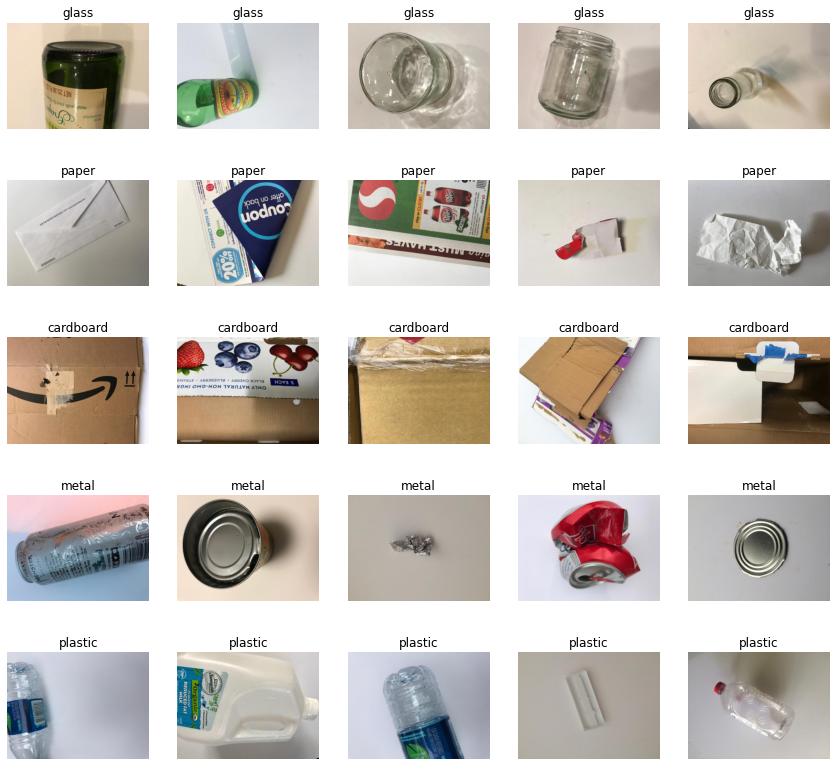

In [ ]:
# plotting images of different classes

plt.figure(figsize=(30,14))

for i in range(5):
    directory = os.path.join(main_dir, classes[i])
    for j in range(5):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        
        plt.subplot(5, 10, i*10 + j + 1)
        plt.imshow(img)
        plt.title(classes[i])
        plt.axis('off')
        


- Before building models, let's prepare images with ImageDataGenerator
- Because the dataset is yet to be split into train set and validation set, let's use validation_split argument in ImageDataGenerator. Then, use flow_from_directory with the subset of 'training' and 'validation' with the same seed. Because the size of dataset is not too large, the external test image is used eventually for testing the model.

In [ ]:
# image augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    main_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    main_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 1914 images belonging to 5 classes.
Found 476 images belonging to 5 classes.


1.1 About the Datasets:
- The garbage dataset consists of 2390 images, which are classified into 5 classes: Glass, Paper, Cardboard, Metal, Plastic


# Build CNN model
- My initial approach for modeling is using the very baseline model used in the Cats&Dogs lab. 


## Model 1: Baseline Model

In [ ]:
#baseline model
def model_maker():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
      MaxPooling2D(2,2),
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Conv2D(128, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Conv2D(128, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Flatten(),
      Dropout(0.5),
      Dense(256, activation='relu'),
      Dense(5, activation='softmax')
  ])
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',     # BE CAREFUL
                metrics = ['accuracy'])
  return model

In [ ]:
model = model_maker()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
# baseline model
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                          restore_best_weights=True)

checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath="my_model_checkpoint_1.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

batch_size = 32
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps, 
                    epochs=20,
                    callbacks=[checkpoint_callback, earlystop],
                    verbose=2)

Epoch 1/20
59/59 - 36s - loss: 2.6931 - accuracy: 0.4134 - val_loss: 1.7565 - val_accuracy: 0.1786

Epoch 00001: val_loss improved from inf to 1.75648, saving model to my_model_checkpoint_1.h5
Epoch 2/20
59/59 - 36s - loss: 2.5840 - accuracy: 0.4182 - val_loss: 1.7431 - val_accuracy: 0.1719

Epoch 00002: val_loss improved from 1.75648 to 1.74312, saving model to my_model_checkpoint_1.h5
Epoch 3/20
59/59 - 36s - loss: 2.4526 - accuracy: 0.4474 - val_loss: 1.7431 - val_accuracy: 0.1763

Epoch 00003: val_loss improved from 1.74312 to 1.74307, saving model to my_model_checkpoint_1.h5
Epoch 4/20
59/59 - 36s - loss: 2.4346 - accuracy: 0.4394 - val_loss: 1.7243 - val_accuracy: 0.1808

Epoch 00004: val_loss improved from 1.74307 to 1.72432, saving model to my_model_checkpoint_1.h5
Epoch 5/20
59/59 - 36s - loss: 2.4160 - accuracy: 0.4283 - val_loss: 1.7221 - val_accuracy: 0.1786

Epoch 00005: val_loss improved from 1.72432 to 1.72210, saving model to my_model_checkpoint_1.h5
Epoch 6/20
59/59 - 

- Results from the baseline models look appalling, val_loss did not improve from 1.709 with validation accuracy are only around 18%.

## Transfer Learning:
- Next step, I opt to Transfer Learning. The main idea of transfer learning is to use the transferred model as feauture extractor.
- Basically, I chose some available CNN models in keras, then chopped off the top layer of the already trained model and replaced it with my own (pretty much random) layers.
- For experiments, I chose MobileNetV2, DenseNet121 and Xception. I freeze up the paramaters of each models and train nothing but my added layers.

## MobileNetV2

In [ ]:
# original MobileNetV2
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# original MobileNetV2
def model_maker():
  model = keras.Sequential([
                            base_model,
                            GlobalAveragePooling2D(input_shape=(4,4,1024)),
                            Dropout(0.5),
                            Dense(5, activation='softmax')
  ])


  model.compile(optimizer= 'adam',
                loss='categorical_crossentropy',     
                metrics = ['accuracy'])
  return model

In [ ]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-2, # "improving" threshold
    patience=10,
    verbose=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_model_checkpoint.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)
history_1 = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint_callback, earlystopping_callback],
                    verbose=2)

Epoch 1/15
60/60 - 229s - loss: 1.5561 - accuracy: 0.2832 - val_loss: 1.4789 - val_accuracy: 0.3361

Epoch 00001: val_loss improved from inf to 1.47888, saving model to my_model_checkpoint.h5
Epoch 2/15
60/60 - 226s - loss: 1.3642 - accuracy: 0.4248 - val_loss: 1.4329 - val_accuracy: 0.3950

Epoch 00002: val_loss improved from 1.47888 to 1.43294, saving model to my_model_checkpoint.h5
Epoch 3/15
60/60 - 225s - loss: 1.2367 - accuracy: 0.4624 - val_loss: 1.5045 - val_accuracy: 0.3697

Epoch 00003: val_loss did not improve from 1.43294
Epoch 4/15
60/60 - 224s - loss: 1.1640 - accuracy: 0.5167 - val_loss: 1.3030 - val_accuracy: 0.4622

Epoch 00004: val_loss improved from 1.43294 to 1.30304, saving model to my_model_checkpoint.h5
Epoch 5/15
60/60 - 230s - loss: 1.0981 - accuracy: 0.5486 - val_loss: 1.2640 - val_accuracy: 0.5063

Epoch 00005: val_loss improved from 1.30304 to 1.26400, saving model to my_model_checkpoint.h5
Epoch 6/15
60/60 - 225s - loss: 1.0055 - accuracy: 0.5998 - val_loss

- After naively and merely applying the MobileNetV2 model, the results are **1.02 for val_loss and 0.60 for val_accuracy**. Therefore, I tried to put on the model some **adjustments on learning rate**.

In [ ]:
#MobileNetV2_2ndtime
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

base_model.trainable = False

In [ ]:
#MobileNetV2_2ndtime
def model_maker():
  model = keras.Sequential([
                            base_model,
                            GlobalAveragePooling2D(),
                            Dense(5, activation='softmax')
  ])


  model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.00001),
                loss='categorical_crossentropy',     
                metrics = ['accuracy'])
  return model

In [ ]:
model = model_maker()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#MobileNetV2_2ndtime (first 100 epochs)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                          restore_best_weights=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_model_checkpoint.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

def step_decay(epoch):
	initial_lrate = 0.0001
	drop_rate = 0.5
	epochs_drop = 4
	lrate = initial_lrate * math.pow(drop_rate, math.floor((epoch)/epochs_drop))
	return lrate

lr_scheduler = keras.callbacks.LearningRateScheduler(step_decay, verbose=1)


history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[checkpoint_callback, lr_scheduler, earlystop], 
                    verbose=1)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 35s 291ms/step - loss: 0.8997 - accuracy: 0.6614 - val_loss: 0.9012 - val_accuracy: 0.6471

Epoch 00001: val_loss improved from inf to 0.90124, saving model to my_model_checkpoint.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 35s 293ms/step - loss: 0.7657 - accuracy: 0.7273 - val_loss: 0.8259 - val_accuracy: 0.6639

Epoch 00002: val_loss improved from 0.90124 to 0.82587, saving model to my_model_checkpoint.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 35s 292ms/step - loss: 0.7001 - accuracy: 0.7524 - val_loss: 0.7748 - val_accuracy: 0.6723

Epoch 00003: val_loss improved from 0.82587 to 0.77482, saving model to my_model_checkpoint.h5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 35s 292ms/step - loss: 0.6563 - accuracy: 0.7696 - val_loss: 0.7390 - val_accuracy: 0.6849

Epoch 00004: val_loss improved from 0.77482 to 0.73903, saving model to my_model_checkpoint.h5
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning ra

In [ ]:
##MobileNetV2_2ndtime (next 70 epochs)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                          restore_best_weights=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_model_checkpoint_dense121.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

def step_decay(epoch):
	initial_lrate = 0.0001
	drop_rate = 0.5
	epochs_drop = 4
	lrate = initial_lrate * math.pow(drop_rate, math.floor((epoch)/epochs_drop))
	return lrate

lr_scheduler = keras.callbacks.LearningRateScheduler(step_decay, verbose=1)


history = model.fit(train_generator,
                    epochs=70,
                    validation_data=validation_generator,
                    callbacks=[checkpoint_callback, lr_scheduler, earlystop], 
                    verbose=1)

Epoch 1/70

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 36s 300ms/step - loss: 0.4117 - accuracy: 0.8636 - val_loss: 0.5512 - val_accuracy: 0.7647

Epoch 00001: val_loss improved from inf to 0.55125, saving model to my_model_checkpoint_dense121.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/70

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 36s 297ms/step - loss: 0.4034 - accuracy: 0.8631 - val_loss: 0.5470 - val_accuracy: 0.7626

Epoch 00002: val_loss improved from 0.55125 to 0.54699, saving model to my_model_checkpoint_dense121.h5
Epoch 3/70

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 36s 301ms/step - loss: 0.3925 - accuracy: 0.8574 - val_loss: 0.5420 - val_accuracy: 0.7689

Epoch 00003: val_loss improved from 0.54699 to 0.54199, saving model to my_model_checkpoint_dense121.h5
Epoch 4/70

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 36s 302ms/step - loss: 0.3830 - accuracy: 0.8668 - val_loss: 0.5386 - val_accuracy: 0.7689

Epoch 00004: val_loss improved from 0.54199 to 0.53863, saving model to my_model_checkpoint_dense121.h5
Epoch 5/70

Epoch 00005: LearningRateSchedu

- Yep, after a lengthy 170 epochs of MobileNetV2, the best score I got is **0.52 for val_loss and 0.76 for val_accuracy**. I still need to go deeper!
- However, one take-away from experimenting MobileNetV2 is tuning hyperparameters for callbacks and learning rate decay. Accordingly, I use them for the next models.

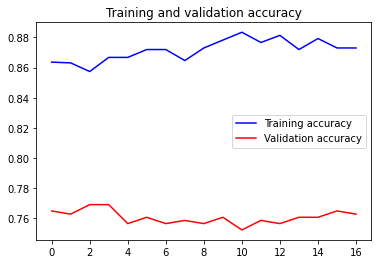

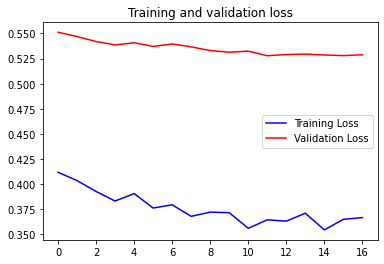

In [ ]:
acc_loss_graph(history)

## DenseNet

In [ ]:
from tensorflow.keras.applications import DenseNet121

conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze the layers in conv_base
conv_base.trainable = False

In [ ]:
# densenet121
def model_maker():
  model = keras.Sequential([
                            conv_base,
                            GlobalAveragePooling2D(),
                            Dropout(0.5),
                            Dense(5, activation='softmax')
  ])

  
  model.compile(optimizer= tf.keras.optimizers.Adam(0.00001),
                loss='categorical_crossentropy',    
                metrics = ['accuracy'])
  return model

In [ ]:
model_densenet121 = model_maker()
model_densenet121.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 5,125
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
#densenet121 
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                          restore_best_weights=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_model_checkpoint_dense121.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

def step_decay(epoch):
	initial_lrate = 0.0001
	drop_rate = 0.5
	epochs_drop = 4
	lrate = initial_lrate * math.pow(drop_rate, math.floor((epoch)/epochs_drop))
	return lrate

lr_scheduler = keras.callbacks.LearningRateScheduler(step_decay, verbose=1)


history_dense121 = model_densenet121.fit(train_generator,
                    epochs=70,
                    validation_data=validation_generator,
                    callbacks=[checkpoint_callback, lr_scheduler, earlystop], 
                    verbose=1)

Epoch 1/70

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 54s 377ms/step - loss: 2.2322 - accuracy: 0.1808 - val_loss: 1.6891 - val_accuracy: 0.2563

Epoch 00001: val_loss improved from inf to 1.68915, saving model to my_model_checkpoint_dense121.h5
Epoch 2/70

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 41s 339ms/step - loss: 1.8984 - accuracy: 0.2769 - val_loss: 1.4729 - val_accuracy: 0.3655

Epoch 00002: val_loss improved from 1.68915 to 1.47285, saving model to my_model_checkpoint_dense121.h5
Epoch 3/70

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 41s 339ms/step - loss: 1.6623 - accuracy: 0.3328 - val_loss: 1.3048 - val_accuracy: 0.4475

Epoch 00003: val_loss improved from 1.47285 to 1.30478, saving model to my_model_checkpoint_dense121.h5
Epoch 4/70

Epoch 00004: LearningRateScheduler 

In [ ]:
history_dense121_v2 = model_densenet121.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    callbacks=[checkpoint_callback, lr_scheduler, earlystop], 
                    verbose=1)

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 39s 328ms/step - loss: 1.0528 - accuracy: 0.5883 - val_loss: 0.8922 - val_accuracy: 0.6534

Epoch 00001: val_loss improved from 0.92710 to 0.89216, saving model to my_model_checkpoint_dense121.h5
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 39s 325ms/step - loss: 1.0090 - accuracy: 0.6092 - val_loss: 0.8601 - val_accuracy: 0.6639

Epoch 00002: val_loss improved from 0.89216 to 0.86014, saving model to my_model_checkpoint_dense121.h5
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 39s 320ms/step - loss: 0.9773 - accuracy: 0.6212 - val_loss: 0.8325 - val_accuracy: 0.6723

Epoch 00003: val_loss improved from 0.86014 to 0.83251, saving model to my_model_checkpoint_dense121.h5
Epoch 4/30

Epoch 00004: LearningRateSchedu

- Yay, after running 100 epochs using DenseNet121, the best **val_loss is 0.7916 and val_acc is 0.7122**.
- The results using DenseNet121 are not promising.

##Xception

- The Inception module is to make this process easier and more efficient by explicitly factoring it into a series of operations that would independently look at cross-channel correlations and at spatial correlations.

In [ ]:
from tensorflow.keras.applications import Xception

xception_base = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze the layers in conv_base
xception_base.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
#xception
def model_maker():
  model = keras.Sequential([
                            xception_base,
                            GlobalAveragePooling2D(),
                            Dropout(0.5),
                            Dense(5, activation='softmax')
  ])

  
  model.compile(optimizer= tf.keras.optimizers.Adam(0.00001),
                loss='categorical_crossentropy',    
                metrics = ['accuracy'])
  return model

In [ ]:
model_xception = model_maker()
model_xception.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 10,245
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#eception (first 70 epochs)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                          restore_best_weights=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_model_checkpoint_xception.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

def step_decay(epoch):
	initial_lrate = 0.0001
	drop_rate = 0.5
	epochs_drop = 4
	lrate = initial_lrate * math.pow(drop_rate, math.floor((epoch)/epochs_drop))
	return lrate

lr_scheduler = keras.callbacks.LearningRateScheduler(step_decay, verbose=1)


history_xception = model_xception.fit(train_generator,
                    epochs=70,
                    validation_data=validation_generator,
                    callbacks=[checkpoint_callback, lr_scheduler, earlystop], 
                    verbose=1)

Epoch 1/70

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 47s 356ms/step - loss: 1.5092 - accuracy: 0.3427 - val_loss: 1.2482 - val_accuracy: 0.5546

Epoch 00001: val_loss improved from inf to 1.24818, saving model to my_model_checkpoint_xception.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/70

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 40s 337ms/step - loss: 1.1928 - accuracy: 0.5465 - val_loss: 1.0251 - val_accuracy: 0.6807

Epoch 00002: val_loss improved from 1.24818 to 1.02511, saving model to my_model_checkpoint_xception.h5
Epoch 3/70

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 40s 333ms/step - loss: 0.9735 - accuracy: 0.6625 - val_loss: 0.8945 - val_accuracy: 0.7227

Epoch 00003: val_loss improved from 1.02511 to 0.89446, saving model to my_model_checkpoint_xception.h5
Epoch 4/70

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 40s 333ms/step - loss: 0.8610 - accuracy: 0.7220 - val_loss: 0.8099 - val_accuracy: 0.7290

Epoch 00004: val_loss improved from 0.89446 to 0.80992, saving model to my_model_checkpoint_xception.h5
Epoch 5/70

Epoch 00005: LearningRateSchedu

In [ ]:
#xception (next 50 epochs)
history_xception_v2 = model_xception.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    callbacks=[checkpoint_callback, lr_scheduler, earlystop], 
                    verbose=1)

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 41s 338ms/step - loss: 0.6023 - accuracy: 0.7921 - val_loss: 0.6279 - val_accuracy: 0.7668

Epoch 00001: val_loss improved from 0.64851 to 0.62785, saving model to my_model_checkpoint_xception.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 40s 333ms/step - loss: 0.5576 - accuracy: 0.8088 - val_loss: 0.6110 - val_accuracy: 0.7752

Epoch 00002: val_loss improved from 0.62785 to 0.61099, saving model to my_model_checkpoint_xception.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 40s 329ms/step - loss: 0.5447 - accuracy: 0.8182 - val_loss: 0.5967 - val_accuracy: 0.7794

Epoch 00003: val_loss improved from 0.61099 to 0.59675, saving model to my_model_checkpoint_xception.h5
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 39s 328ms/step - loss: 0.5108 - accuracy: 0.8328 - val_loss: 0.5852 - val_accuracy: 0.7857

Epoch 00004: val_loss improved from 0.59675 to 0.58523, saving model to my_model_checkpoint_xception.h5
Epoch 5/50

Epoch 00005: LearningRateSchedu

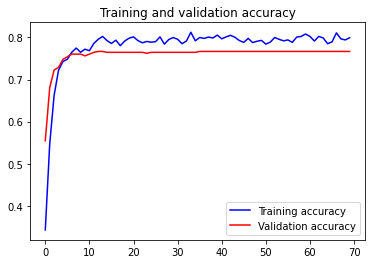

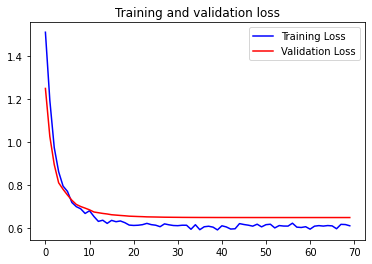

In [ ]:
acc_loss_graph(history_xception)

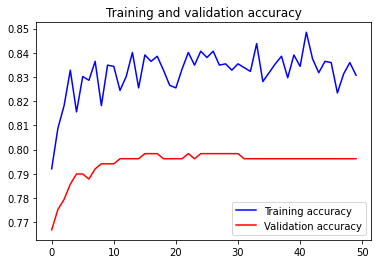

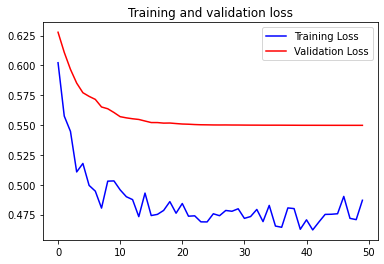

In [ ]:
acc_loss_graph(history_xception_v2)

In [ ]:
val_loss, val_acc = model_xception.evaluate(validation_generator)
print("Validation Set Accuracy: {:5.2f}%".format(val_acc*100))

30/30 [==============================] - 5s 153ms/step - loss: 0.5498 - accuracy: 0.7962
Validation Set Accuracy: 79.62%


- So far so good. Xception offers the best score for **validation set accuracy at 79.62**%. Next, let's tune this model.
- Xception architecture includes 36 convolutional layers are structured into 14 modules, all of which have linear residual connections around them, except for the first and last modules like this:
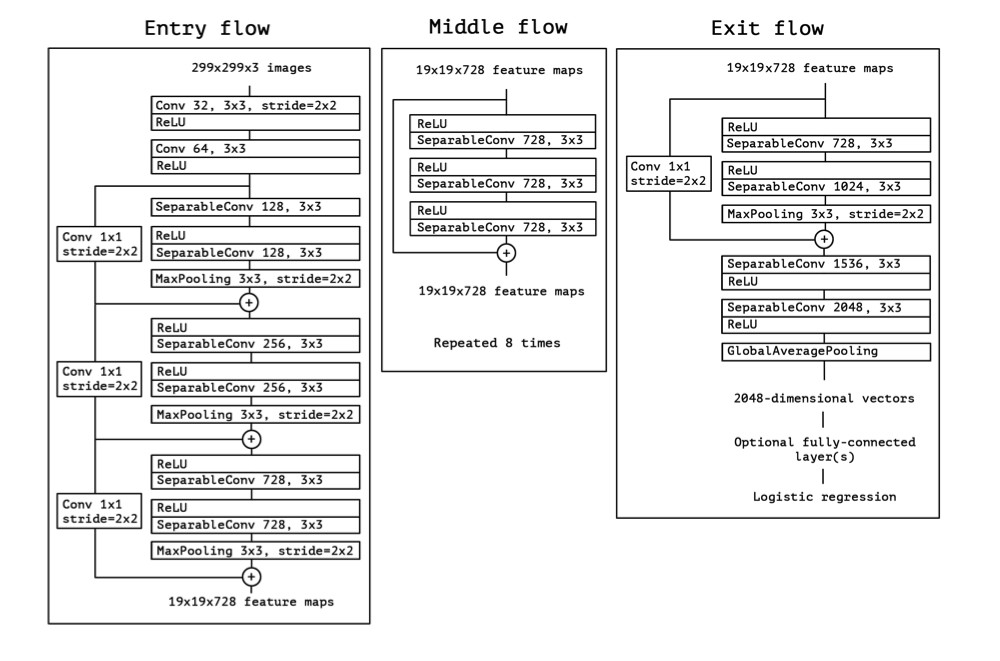

In [ ]:
xception_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

- Randomly, I decided keep entry flow and middle flow fixed and replace the exit flow with my own layers.

In [ ]:
#freeze the layers in conv_base
xception_base.trainable = True

# find the tunning layer and its index
tuning_layer_name = 'block13_sepconv1_act'
tuning_layer = xception_base.get_layer(tuning_layer_name)
tuning_index = xception_base.layers.index(tuning_layer)

# freeze all the layers before the tuning layer
for layer in xception_base.layers[:tuning_index]:
    layer.trainable =  False

In [ ]:
def model_maker():
  model = keras.Sequential([
                            xception_base,
                            GlobalAveragePooling2D(),
                            Dropout(0.2),
                            Dense(512, activation='relu'),
                            Dense(5, activation='softmax')
  ])

  
  model.compile(optimizer= tf.keras.optimizers.Adam(0.00001),
                loss='categorical_crossentropy',    
                metrics = ['accuracy'])
  return model

In [ ]:
model_xception_tuning = model_maker()
model_xception_tuning.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 21,913,133
Trainable params: 7,840,037
Non-trainable params: 14,073,096
_________________________________________________________________


In [ ]:
#xception tuning
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                          restore_best_weights=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_model_checkpoint_xception_tuning.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

def step_decay(epoch):
	initial_lrate = 0.0001
	drop_rate = 0.5
	epochs_drop = 4
	lrate = initial_lrate * math.pow(drop_rate, math.floor((epoch)/epochs_drop))
	return lrate

lr_scheduler = keras.callbacks.LearningRateScheduler(step_decay, verbose=1)


history_xception_tuning = model_xception_tuning.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    batch_size=32,
                    callbacks=[checkpoint_callback, lr_scheduler, earlystop], 
                    verbose=1)

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
60/60 [==============================] - 1054s 17s/step - loss: 0.8049 - accuracy: 0.7356 - val_loss: 0.5078 - val_accuracy: 0.8109

Epoch 00001: val_loss improved from inf to 0.50784, saving model to my_model_checkpoint_xception_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
60/60 [==============================] - 1051s 18s/step - loss: 0.2971 - accuracy: 0.9018 - val_loss: 0.3776 - val_accuracy: 0.8445

Epoch 00002: val_loss improved from 0.50784 to 0.37757, saving model to my_model_checkpoint_xception_tuning.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
60/60 [==============================] - 1042s 17s/step - loss: 0.1993 - accuracy: 0.9331 - val_loss: 0.3791 - val_accuracy: 0.8508

Epoch 00003: val_loss did not improve from 0.37757
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
60/60 [==============================] - 1039s 17s/step - loss: 0.1452 - accuracy: 0.9498 - val_loss: 0.3227 - val_accuracy: 0.8824

Epoch 00004: val_loss improved from 0.37757 to 0.32265, saving model to my_model_checkpoint_xception_tuning.h5
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 5e-05.
60/60 [==

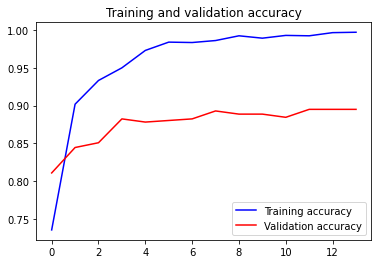

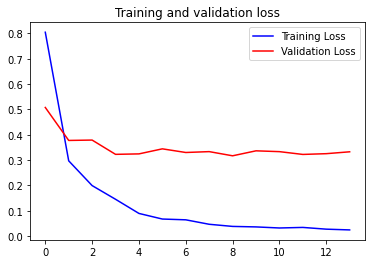

In [ ]:
acc_loss_graph(history_xception_tuning)

In [ ]:
val_loss, val_acc = model_xception_tuning.evaluate(validation_generator)
print("Validation Set Accuracy: {:5.2f}%".format(val_acc*100))

15/15 [==============================] - 154s 10s/step - loss: 0.3169 - accuracy: 0.8887
Validation Set Accuracy: 88.87%


- The best score I got for validation set accuracy is 88.87%

# External Test Image

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  img_path = './' + fn

Saving cardboard.jpg to cardboard (6).jpg
cardboard.jpg


In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
def predict_test_image(img_path):
  test_image = image.load_img(img_path, target_size=(224,224))
  plt.imshow(test_image)
  test_image = image.img_to_array(test_image)
  test_image = test_image / 255.
  test_image = np.expand_dims(test_image,axis=0)
  pred = model_xception_tuning.predict(test_image)

  for key, value in validation_generator.class_indices.items():
    if value == pred[0].argmax():
      pred = key


Cardboard


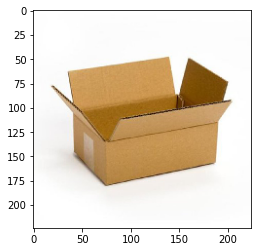

In [ ]:
predict_test_image(img_path)

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  img_path = './' + fn

Saving metal.jpg to metal (4).jpg
metal.jpg


Metal


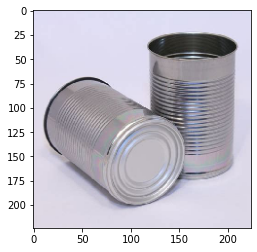

In [ ]:
predict_test_image(img_path)